In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        # Define a simple architecture
        self.fc1 = nn.Linear(28*28, 128)  # Example for MNIST dataset
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [2]:
# Initialize network and other training components
seed_net = SeedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seed_net.parameters(), lr=0.001)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


In [3]:
# Train the network
for epoch in range(5):  # You can adjust the number of epochs
    for data, target in train_loader:
        optimizer.zero_grad()
        output = seed_net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Identify critical connections (heuristic approach)
# For simplicity, let's assume we're looking at the weights of the last layer
weights = seed_net.fc2.weight.data.abs().mean(dim=1)
critical_neurons = weights.argsort(descending=True)[:10]  # Top 10 neurons


Epoch 1, Loss: 0.23354165256023407
Epoch 2, Loss: 0.07264916598796844
Epoch 3, Loss: 0.03728631138801575
Epoch 4, Loss: 0.02491454780101776
Epoch 5, Loss: 0.0325070321559906


In [29]:
# Define pruning function
def prune_network(model, prune_percentage):
    _, idx = model.fc2.weight.data.abs().flatten().sort()
    num_prune = int(len(idx) * prune_percentage)
    prune_idx = idx[:num_prune]
    model.fc2.weight.data.view(-1)[prune_idx] = 0
    model.fc2.weight.grad = None  # Optional: Remove gradients for pruned weights

# Define retraining function
def retrain_network(model, train_loader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Define validation function
def validate_network(model, validation_loader, criterion):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            output = model(data)
            validation_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    validation_loss /= len(validation_loader.dataset)
    validation_accuracy = 100. * correct / len(validation_loader.dataset)
    return validation_loss, validation_accuracy



Iteration 0: Validation Loss: 0.0011, Validation Accuracy: 97.99%
Iteration 1: Validation Loss: 0.0013, Validation Accuracy: 97.65%
Iteration 2: Validation Loss: 0.0012, Validation Accuracy: 97.92%
Iteration 3: Validation Loss: 0.0013, Validation Accuracy: 97.84%
Iteration 4: Validation Loss: 0.0015, Validation Accuracy: 97.78%
Iteration 5: Validation Loss: 0.0019, Validation Accuracy: 97.42%
Iteration 6: Validation Loss: 0.0015, Validation Accuracy: 98.11%
Iteration 7: Validation Loss: 0.0017, Validation Accuracy: 97.99%
Iteration 8: Validation Loss: 0.0023, Validation Accuracy: 97.31%
Iteration 9: Validation Loss: 0.0018, Validation Accuracy: 98.08%


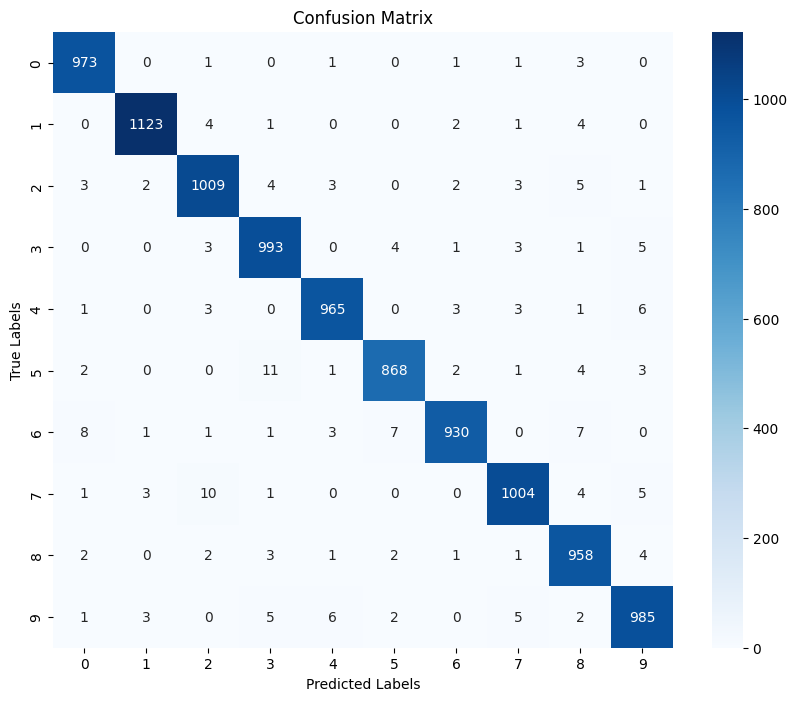

Precision: 0.9807, Recall: 0.9806


In [31]:
# Iterative pruning and validation
prune_percentage = 0.1  # Prune 10% of the connections each iteration
num_iterations = 10
acceptable_accuracy_drop = 0.5  # Acceptable drop in accuracy percentage

initial_loss, initial_accuracy = validate_network(seed_net, test_loader, criterion)

for iteration in range(num_iterations):
    # Prune the network
    prune_network(seed_net, prune_percentage)
    
    # Retrain (fine-tune) the network
    retrain_network(seed_net, train_loader, optimizer, criterion, epochs=3)
    
    # Validate the performance
    validation_loss, validation_accuracy = validate_network(seed_net, test_loader, criterion)
    
    print(f"Iteration {iteration}: Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")
    
    # Check if performance is acceptable
    if initial_accuracy - validation_accuracy > acceptable_accuracy_drop:
        print(f"Stopping early at iteration {iteration} due to performance degradation beyond acceptable drop of {acceptable_accuracy_drop}%.")
        break

# Evaluate model performance after pruning
evaluate_model_performance(seed_net, test_loader)

In [28]:
# seed_net.fc2.weight.data[3]

In [20]:
print(seed_net.fc2.weight.data.shape)
print(seed_net.fc1.weight.data.shape)

torch.Size([10, 128])
torch.Size([128, 784])


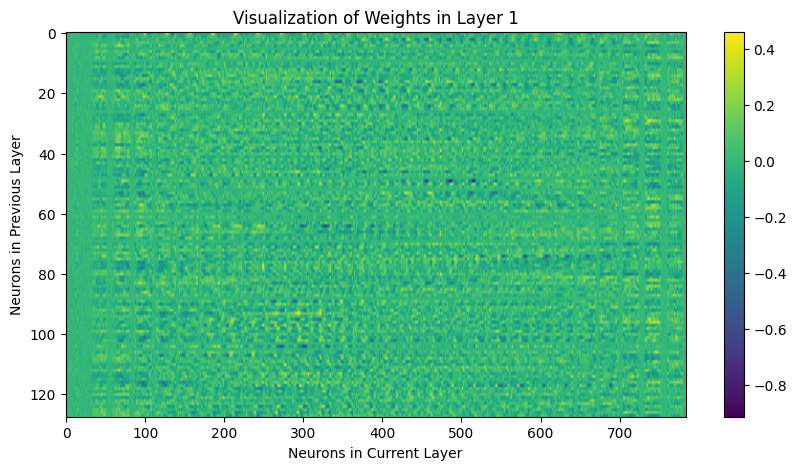

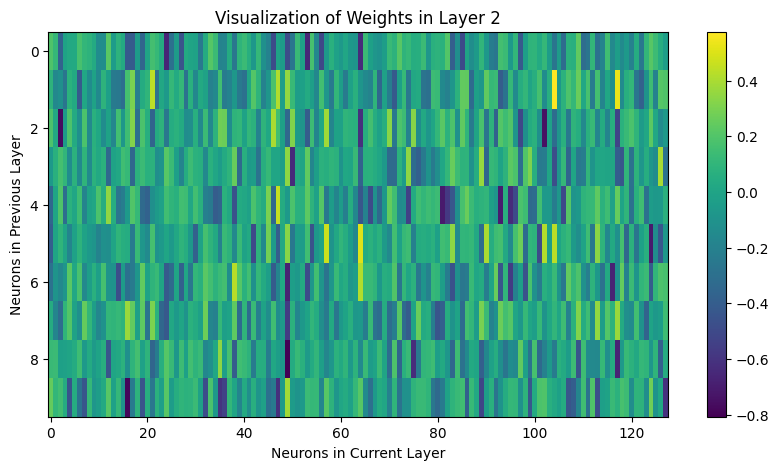

In [4]:
def plot_nn_structure(model):
    for i, layer in enumerate([model.fc1, model.fc2]):
        weights = layer.weight.data
        plt.figure(figsize=(10, 5))
        plt.imshow(weights, cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.title(f'Visualization of Weights in Layer {i+1}')
        plt.xlabel('Neurons in Current Layer')
        plt.ylabel('Neurons in Previous Layer')
        plt.show()

plot_nn_structure(seed_net)


In [30]:
# Load test data
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Evaluate the model
seed_net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = seed_net(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)')


Test set: Average loss: 0.0012, Accuracy: 9755/10000 (98%)


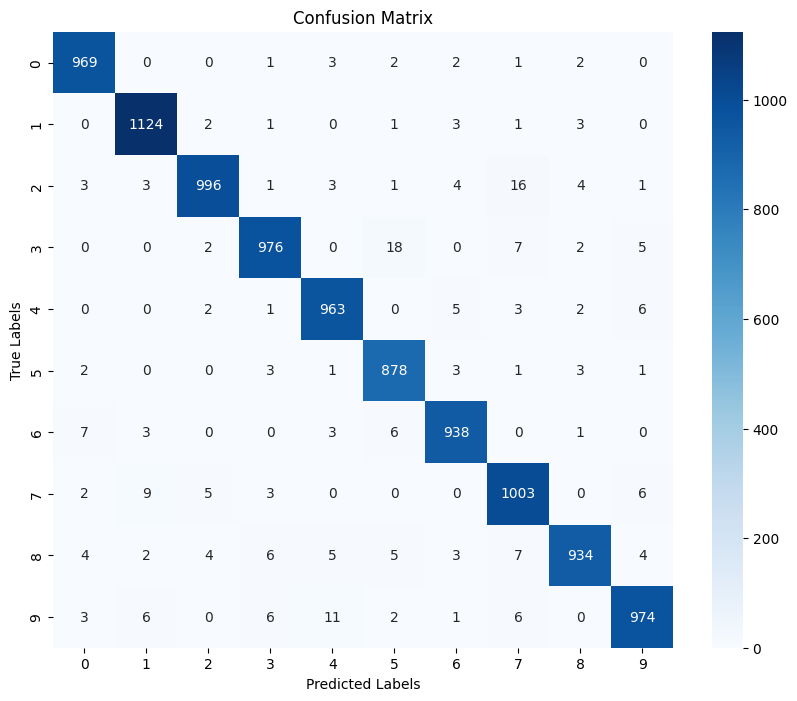

Precision: 0.9754, Recall: 0.9755


In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

def evaluate_model_performance(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True).view_as(target)
            all_preds.extend(preds.numpy())
            all_targets.extend(target.numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision and Recall
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')

evaluate_model_performance(seed_net, test_loader)


In [4]:
class GrownNet(nn.Module):
    def __init__(self, critical_neurons):
        super(GrownNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        # Adding a new layer connected to critical neurons
        self.fc3 = nn.Linear(10, 10)
        self.critical_neurons = critical_neurons

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        critical_output = x[:, self.critical_neurons]  # Use only critical outputs
        x = self.fc3(critical_output)
        return x

In [5]:
grown_net = GrownNet(critical_neurons=critical_neurons)

optimizer = optim.Adam(grown_net.parameters(), lr=0.001)

# Retrain the grown network
for epoch in range(5):  # Adjust the number of epochs as needed
    for data, target in train_loader:
        optimizer.zero_grad()
        output = grown_net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.21254152059555054
Epoch 2, Loss: 0.44402918219566345
Epoch 3, Loss: 0.06499005109071732
Epoch 4, Loss: 0.03586699813604355
Epoch 5, Loss: 0.010463601909577847


In [6]:
# You would typically use a separate validation dataset here
# For simplicity, reusing the training data loader in this example
correct = 0
total = 0
with torch.no_grad():
    for data, target in train_loader:
        output = grown_net(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 98.625%


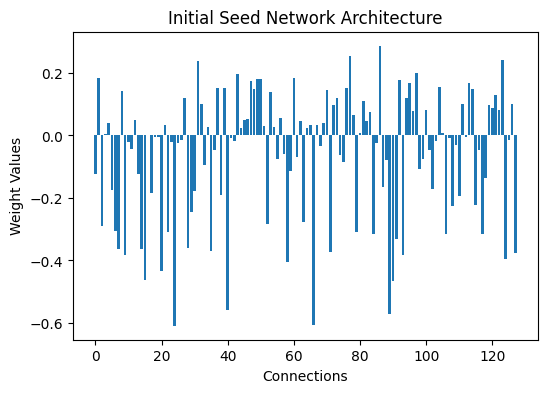

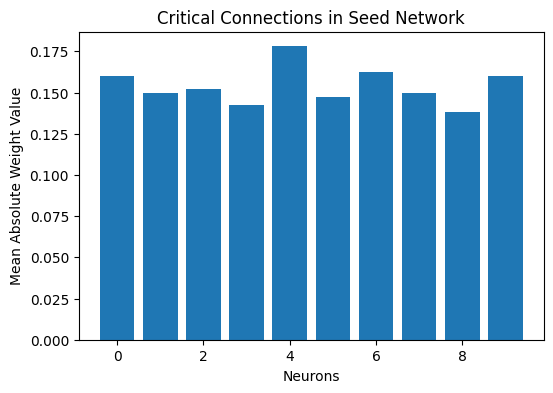

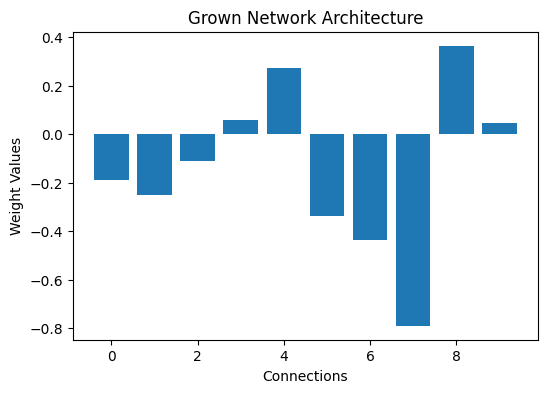

In [7]:
# Visualize the initial seed network
plt.figure(figsize=(6, 4))
plt.title("Initial Seed Network Architecture")
plt.bar(range(len(seed_net.fc2.weight[0])), seed_net.fc2.weight[0].detach().numpy())
plt.xlabel("Connections")
plt.ylabel("Weight Values")
plt.show()

# Visualize critical connections
plt.figure(figsize=(6, 4))
plt.title("Critical Connections in Seed Network")
plt.bar(range(len(weights)), weights.detach().numpy())
plt.xlabel("Neurons")
plt.ylabel("Mean Absolute Weight Value")
plt.show()

# Visualize the grown network
plt.figure(figsize=(6, 4))
plt.title("Grown Network Architecture")
plt.bar(range(len(grown_net.fc3.weight[0])), grown_net.fc3.weight[0].detach().numpy())
plt.xlabel("Connections")
plt.ylabel("Weight Values")
plt.show()

In [8]:
def visualize_feature_maps(model, input_image):
    model.eval()
    with torch.no_grad():
        # Assuming 'model' is your CNN and has a feature layer named 'conv1'
        feature_maps = model.conv1(input_image)

    # Plotting the feature maps
    num_feature_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 20))
    for i, ax in enumerate(axes):
        ax.imshow(feature_maps[0, i].cpu(), cmap='gray')
        ax.axis('off')
    plt.show()